In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"
# had to set this env var to avoid this issue:
# https://stackoverflow.com/questions/75583410/module-save-error-typeerror-this-dict-descriptor-does-not-support-dict
os.environ["WRAPT_DISABLE_EXTENSIONS"] = "true"

import tensorflow as tf
import pandas as pd
import keras
import keras.layers as layers
from keras.utils import FeatureSpace
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
import pprint as pp
from tensorflow import Tensor
from keras.models import Model
from pandas import DataFrame
from typing import List, Dict, Tuple, Any


def dataframe_to_dataset(dataframe: DataFrame, task_cols: List[str]) -> tf.data.Dataset:
    dataframe = dataframe.copy()
    labels = {col: dataframe.pop(col) for col in task_cols}
    weights = {
        f"{col}_sample_weights": dataframe.pop(f"{col}_sample_weights")
        for col in task_cols
    }

    ds = tf.data.Dataset.from_tensor_slices(
        tensors=(dict(dataframe), labels, weights), name="df_to_ds"
    )
    ds = ds.shuffle(buffer_size=len(dataframe))

    return ds


def preprocess_dataset(
    feature_space: FeatureSpace,
    features: Dict[str, Tensor],
    labels: Dict[str, Tensor],
    weights: Dict[str, Tensor],
    task_cols: List[str],
) -> Tuple[Dict[str, Tensor], Dict[str, Tensor], Dict[str, Tensor]]:
    adjusted_labels = {task_col: labels[task_col] for task_col in task_cols}
    sample_weights = {
        task_col: weights[f"{task_col}_sample_weights"] for task_col in task_cols
    }

    return feature_space(features), adjusted_labels, sample_weights


def expert_network(
    input_tensor: Tensor,
    dense_units: List[int] = [32],
    dropout_rate: float = 0.5,
    activation: str = "relu",
    expert_index: int = 0,  # Added an index for naming
) -> Tensor:
    x = input_tensor
    for idx, units in enumerate(dense_units):
        x = layers.Dense(
            units, activation=activation, name=f"expert_{expert_index}_dense_{idx}"
        )(x)
        x = layers.Dropout(dropout_rate, name=f"expert_{expert_index}_dropout_{idx}")(x)

    return x


def gating_network(
    input_tensor: Tensor,
    num_experts: int,
    task_name: str,
    activation: str = "softmax",
) -> Tensor:
    return layers.Dense(num_experts, activation=activation, name=f"gating_{task_name}")(
        input_tensor
    )


def combine_experts(
    experts: List[Tensor], gating_weights: Tensor, task_name: str
) -> Tensor:
    weighted_experts = [
        layers.Multiply(name=f"weighted_expert_{task_name}_{i}")(
            [gating_weights[:, i : i + 1], expert]
        )
        for i, expert in enumerate(experts)
    ]

    return layers.Add(name=f"combined_experts_{task_name}")(weighted_experts)


class ModelBuilder:
    def __init__(
        self,
        feature_space: FeatureSpace,
        num_experts: int = 2,
        experts_dense_units: List[int] = [32],
        experts_dropout_rate: float = 0.5,
        experts_activation: str = "relu",
        gating_activation: str = "softmax",
        prediction_activation: str = "sigmoid",
        task_cols: List[str] = ["task_one", "task_two"],
    ):
        self.feature_space = feature_space
        self.num_experts = num_experts
        self.experts_dense_units = experts_dense_units
        self.experts_dropout_rate = experts_dropout_rate
        self.experts_activation = experts_activation
        self.gating_activation = gating_activation
        self.prediction_activation = prediction_activation
        self.task_cols = task_cols
        self.input_features_encoded = feature_space.get_encoded_features()
        self.input_features_dict = feature_space.get_inputs()
        self.experts = [
            expert_network(
                self.input_features_encoded,
                expert_index=i,
                dense_units=self.experts_dense_units,
                dropout_rate=self.experts_dropout_rate,
                activation=self.experts_activation,
            )
            for i in range(self.num_experts)
        ]

    def build_models(self) -> Tuple[Model, Model]:
        gating_models = []
        prediction_models = []

        for task_col in self.task_cols:
            gating_task = gating_network(
                self.input_features_encoded,
                self.num_experts,
                task_col,
                self.gating_activation,
            )
            predictions_task = combine_experts(self.experts, gating_task, task_col)
            predictions_task = layers.Dense(
                1, activation=self.prediction_activation, name=task_col
            )(predictions_task)

            gating_models.append(gating_task)
            prediction_models.append(predictions_task)

        training_model = keras.Model(
            inputs=self.input_features_encoded,
            outputs=prediction_models,
            name="training_model",
        )
        inference_model = keras.Model(
            inputs=self.input_features_dict,
            outputs=prediction_models,
            name="inference_model",
        )

        return training_model, inference_model


def brier_score(y_true: Tensor, y_pred: Tensor) -> Tensor:
    return tf.reduce_mean(tf.math.square(y_true - y_pred), axis=-1)


def mae(y_true: Tensor, y_pred: Tensor) -> Tensor:
    return tf.reduce_mean(tf.abs(y_true - y_pred), axis=-1)

# Params


In [2]:
# params
task_cols = ["task_one", "task_two"]
val_frac = 0.2
random_seed = 1337
ds_batch_size = 32
features = {
    # Categorical features encoded as integers
    "sex": FeatureSpace.integer_categorical(num_oov_indices=0),
    "cp": FeatureSpace.integer_categorical(num_oov_indices=0),
    "fbs": FeatureSpace.integer_categorical(num_oov_indices=0),
    "restecg": FeatureSpace.integer_categorical(num_oov_indices=0),
    "exang": FeatureSpace.integer_categorical(num_oov_indices=0),
    "ca": FeatureSpace.integer_categorical(num_oov_indices=0),
    # Categorical feature encoded as string
    "thal": FeatureSpace.string_categorical(num_oov_indices=0),
    # Numerical features to discretize
    "age": FeatureSpace.float_discretized(num_bins=30),
    # Numerical features to normalize
    "trestbps": FeatureSpace.float_normalized(),
    "chol": FeatureSpace.float_normalized(),
    "thalach": FeatureSpace.float_normalized(),
    "oldpeak": FeatureSpace.float_normalized(),
    "slope": FeatureSpace.float_normalized(),
}
crosses = [
    FeatureSpace.cross(feature_names=("sex", "age"), crossing_dim=64),
    FeatureSpace.cross(
        feature_names=("thal", "ca"),
        crossing_dim=16,
    ),
]
feature_space_output_mode = "concat"
model_num_experts = 2
model_experts_dense_units = [64, 32]
model_experts_dropout_rate = 0.5
model_experts_activation = "relu"
model_gating_activation = "softmax"
model_prediction_activation = "sigmoid"
model_optimizer = "adam"
model_loss_functions = {
    "task_one": "binary_crossentropy",
    "task_two": "binary_crossentropy",
}
model_loss_weights = {"task_one": 0.05, "task_two": 0.95}
model_metrics = {
    "task_one": ["accuracy", brier_score, mae, keras.metrics.AUC()],
    "task_two": ["accuracy", brier_score, mae, keras.metrics.AUC()],
}
model_weighted_metrics = {
    "task_one": ["accuracy", brier_score],
    "task_two": ["accuracy", brier_score],
}
fit_n_epochs = 40
fit_verbose = 2

# 1. Prepare Dataframes


In [3]:
file_url = "http://storage.googleapis.com/download.tensorflow.org/data/heart.csv"
dataframe = pd.read_csv(file_url)
dataframe["task_two"] = np.where(dataframe["slope"] == 2, 1, 0)
dataframe["task_two_sample_weights"] = np.where(dataframe["exang"] == 1, 1, 0)
dataframe["task_one_sample_weights"] = 1
dataframe.rename(columns={"target": "task_one"}, inplace=True)

- We would need to have sample weights & task labels encoded on train/val DF before loading


In [4]:
print(dataframe.shape)

(303, 17)


In [5]:
dataframe.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,task_one,task_two,task_two_sample_weights,task_one_sample_weights
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0,0,0,1
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1,1,1,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0,1,1,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0,0,0,1
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0,0,0,1


In [6]:
val_dataframe = dataframe.sample(frac=val_frac, random_state=random_seed)
train_dataframe = dataframe.drop(val_dataframe.index)

print(
    "Using %d samples for training and %d for validation"
    % (len(train_dataframe), len(val_dataframe))
)

Using 242 samples for training and 61 for validation


# 2. Convert to TF Dataset


In **Process step** we would have:

- Maybe nothing

In **train step** we would have:

- DF to dataset
- Configure & Adapt FeatureSpace
- PreProcess Dataset
- Build Network
- Train Model -> Log to W&B
- Return: **Serialized Python Runtime Model**


In [7]:
train_ds = dataframe_to_dataset(train_dataframe, task_cols)
train_ds = train_ds.batch(ds_batch_size)

val_ds = dataframe_to_dataset(val_dataframe, task_cols)
val_ds = val_ds.batch(ds_batch_size)

In [8]:
pp.pprint(train_ds.element_spec)

({'age': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
  'ca': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
  'chol': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
  'cp': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
  'exang': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
  'fbs': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
  'oldpeak': TensorSpec(shape=(None,), dtype=tf.float64, name=None),
  'restecg': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
  'sex': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
  'slope': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
  'thal': TensorSpec(shape=(None,), dtype=tf.string, name=None),
  'thalach': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
  'trestbps': TensorSpec(shape=(None,), dtype=tf.int64, name=None)},
 {'task_one': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
  'task_two': TensorSpec(shape=(None,), dtype=tf.int32, name=None)},
 {'task_one_sample_

In [9]:
for x, y, w in train_ds.take(1):
    print("Input:\n", x)
    print("Target:\n", y)
    print("Task Weights:\n", w)

Input:
 {'age': <tf.Tensor: shape=(32,), dtype=int64, numpy=
array([52, 48, 58, 46, 54, 47, 58, 68, 42, 44, 65, 65, 35, 57, 42, 51, 57,
       45, 62, 51, 50, 70, 57, 42, 51, 44, 51, 63, 54, 42, 56, 68],
      dtype=int64)>, 'sex': <tf.Tensor: shape=(32,), dtype=int64, numpy=
array([1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 0], dtype=int64)>, 'cp': <tf.Tensor: shape=(32,), dtype=int64, numpy=
array([3, 4, 4, 3, 4, 3, 3, 0, 4, 4, 1, 4, 4, 4, 4, 4, 3, 4, 4, 3, 3, 4,
       4, 2, 3, 2, 4, 1, 4, 3, 4, 3], dtype=int64)>, 'trestbps': <tf.Tensor: shape=(32,), dtype=int64, numpy=
array([172, 124, 146, 142, 110, 108, 132, 144, 102, 110, 138, 120, 138,
       120, 136, 140, 150, 138, 124, 140, 140, 130, 110, 120, 120, 130,
       140, 145, 120, 130, 134, 120], dtype=int64)>, 'chol': <tf.Tensor: shape=(32,), dtype=int64, numpy=
array([199, 274, 218, 177, 206, 243, 224, 193, 265, 197, 282, 177, 183,
       354, 315, 261, 168, 236, 209, 308,

# 3. Configure & Adapt FeatureSpace


In [10]:
feature_space = FeatureSpace(
    features=features,
    crosses=crosses,
    output_mode=feature_space_output_mode,
)

In [11]:
# pp.pprint(feature_space.get_config())

In [12]:
train_ds_with_no_labels = train_ds.map(lambda x, y, z: x)
feature_space.adapt(train_ds_with_no_labels)

In [13]:
pp.pprint(train_ds_with_no_labels.element_spec)

{'age': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
 'ca': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
 'chol': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
 'cp': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
 'exang': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
 'fbs': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
 'oldpeak': TensorSpec(shape=(None,), dtype=tf.float64, name=None),
 'restecg': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
 'sex': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
 'slope': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
 'thal': TensorSpec(shape=(None,), dtype=tf.string, name=None),
 'thalach': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
 'trestbps': TensorSpec(shape=(None,), dtype=tf.int64, name=None)}


In [14]:
# get feature_space info
feature_space_info = feature_space.get_config()
# select a random feature
random_feature = np.random.choice(list(feature_space_info["features"].keys()))
print("Random feature:", random_feature)
pp.pprint(feature_space_info["features"][random_feature])

Random feature: thalach
{'class_name': 'Feature',
 'config': {'dtype': 'float32',
            'output_mode': 'float',
            'preprocessor': {'build_config': {'input_shape': (None, 1)},
                             'class_name': 'Normalization',
                             'config': {'axis': (-1,),
                                        'batch_input_shape': (None, None),
                                        'dtype': 'float32',
                                        'invert': False,
                                        'mean': None,
                                        'name': 'float_normalized_3_preprocessor',
                                        'trainable': True,
                                        'variance': None},
                             'module': 'keras.layers',
                             'registered_name': None}},
 'module': 'keras.src.utils.feature_space',
 'registered_name': 'Feature'}


In [15]:
for x, y, weights in train_ds.take(1):
    preprocessed_x = feature_space(x)
    print("preprocessed_x:\n", preprocessed_x)

preprocessed_x:
 tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(32, 138), dtype=float32)


# 4. Pre-process Data Before Feeding to the Model


In [16]:
preprocessed_train_ds = train_ds.map(
    lambda features, labels, weights: preprocess_dataset(
        feature_space, features, labels, weights, task_cols
    ),
    num_parallel_calls=tf.data.AUTOTUNE,
)
preprocessed_train_ds = preprocessed_train_ds.prefetch(tf.data.AUTOTUNE)
pp.pprint(preprocessed_train_ds.element_spec)

preprocessed_val_ds = val_ds.map(
    lambda features, labels, weights: preprocess_dataset(
        feature_space, features, labels, weights, task_cols
    ),
    num_parallel_calls=tf.data.AUTOTUNE,
)
preprocessed_val_ds = preprocessed_val_ds.prefetch(tf.data.AUTOTUNE)
pp.pprint(preprocessed_train_ds.element_spec)

(TensorSpec(shape=(None, 138), dtype=tf.float32, name=None),
 {'task_one': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
  'task_two': TensorSpec(shape=(None,), dtype=tf.int32, name=None)},
 {'task_one': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
  'task_two': TensorSpec(shape=(None,), dtype=tf.int32, name=None)})
(TensorSpec(shape=(None, 138), dtype=tf.float32, name=None),
 {'task_one': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
  'task_two': TensorSpec(shape=(None,), dtype=tf.int32, name=None)},
 {'task_one': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
  'task_two': TensorSpec(shape=(None,), dtype=tf.int32, name=None)})


# 5. Build the Model


In [17]:
# Build the model
model_builder = ModelBuilder(
    task_cols=task_cols,
    feature_space=feature_space,
    num_experts=model_num_experts,
    experts_dense_units=model_experts_dense_units,
    experts_dropout_rate=model_experts_dropout_rate,
    experts_activation=model_experts_activation,
    gating_activation=model_gating_activation,
    prediction_activation=model_prediction_activation,
)
training_model, inference_model = model_builder.build_models()

# Compile the training model
training_model.compile(
    optimizer=model_optimizer,
    loss=model_loss_functions,
    metrics=model_metrics,
    weighted_metrics=model_weighted_metrics,
    loss_weights=model_loss_weights,
)

In [18]:
# print training model summary
training_model.summary()

Model: "training_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 138)]                0         []                            
                                                                                                  
 expert_0_dense_0 (Dense)    (None, 64)                   8896      ['input_1[0][0]']             
                                                                                                  
 expert_1_dense_0 (Dense)    (None, 64)                   8896      ['input_1[0][0]']             
                                                                                                  
 expert_0_dropout_0 (Dropou  (None, 64)                   0         ['expert_0_dense_0[1][0]']    
 t)                                                                                  

In [19]:
# print model diagram
keras.utils.plot_model(
    training_model,
    show_shapes=True,
    show_layer_names=True,
    show_trainable=True,
    rankdir="TB",
)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [20]:
history = training_model.fit(
    preprocessed_train_ds,
    epochs=fit_n_epochs,
    validation_data=preprocessed_val_ds,
    verbose=fit_verbose,
)

Epoch 1/40

8/8 - 7s - loss: 0.2493 - task_one_loss: 0.7329 - task_two_loss: 0.2239 - task_one_accuracy: 0.4752 - task_one_brier_score: 0.2684 - task_one_mae: 0.5041 - task_one_auc: 0.3815 - task_one_weighted_accuracy: 0.4752 - task_one_weighted_brier_score: 0.2684 - task_two_accuracy: 0.4793 - task_two_brier_score: 0.2573 - task_two_mae: 0.4970 - task_two_auc_1: 0.5183 - task_two_weighted_accuracy: 0.5128 - task_two_weighted_brier_score: 0.2503 - val_loss: 0.2509 - val_task_one_loss: 0.6660 - val_task_two_loss: 0.2291 - val_task_one_accuracy: 0.6885 - val_task_one_brier_score: 0.2364 - val_task_one_mae: 0.4812 - val_task_one_auc: 0.2599 - val_task_one_weighted_accuracy: 0.6885 - val_task_one_weighted_brier_score: 0.2364 - val_task_two_accuracy: 0.7049 - val_task_two_brier_score: 0.2335 - val_task_two_mae: 0.4797 - val_task_two_auc_1: 0.7403 - val_task_two_weighted_accuracy: 0.7143 - val_task_two_weighted_brier_score: 0.2361 - 7s/epoch - 858ms/step
Epoch 2/40
8/8 - 1s - loss: 0.2329 - 

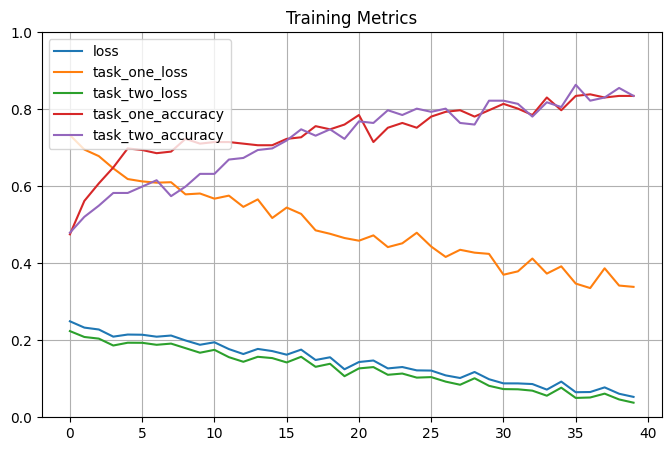

In [21]:
# plot loss curves
cols = [
    "loss",
    "task_one_loss",
    "task_two_loss",
    "task_one_accuracy",
    "task_two_accuracy",
]
pd.DataFrame(history.history)[cols].plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.title("Training Metrics")
plt.show()

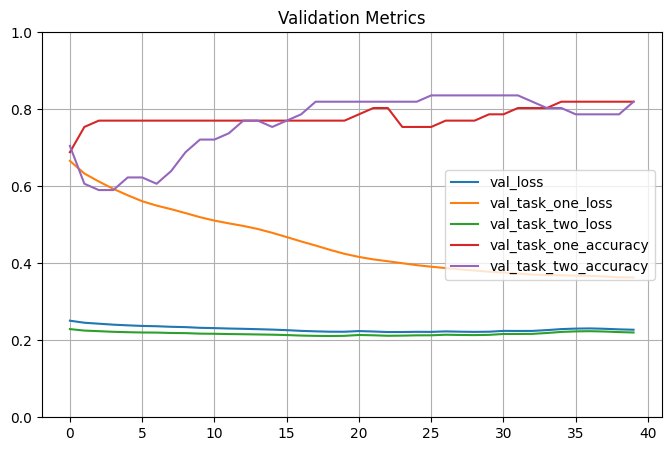

In [22]:
# plot val loss curves
cols = [
    "val_loss",
    "val_task_one_loss",
    "val_task_two_loss",
    "val_task_one_accuracy",
    "val_task_two_accuracy",
]
pd.DataFrame(history.history)[cols].plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.title("Validation Metrics")
plt.show()

In [23]:
pp.pprint(training_model.outputs)

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'task_one')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'task_two')>]


In [24]:
pp.pprint(training_model.outputs[0].shape)
pp.pprint(training_model.outputs[1].shape)

TensorShape([None, 1])
TensorShape([None, 1])


In [25]:
print(len(training_model.layers))

23


In [26]:
pp.pprint(training_model.layers)

# 6. Batch Predict on Val Set & Plot Calibration Curves


2/2 [==============================] - 1s 7ms/step


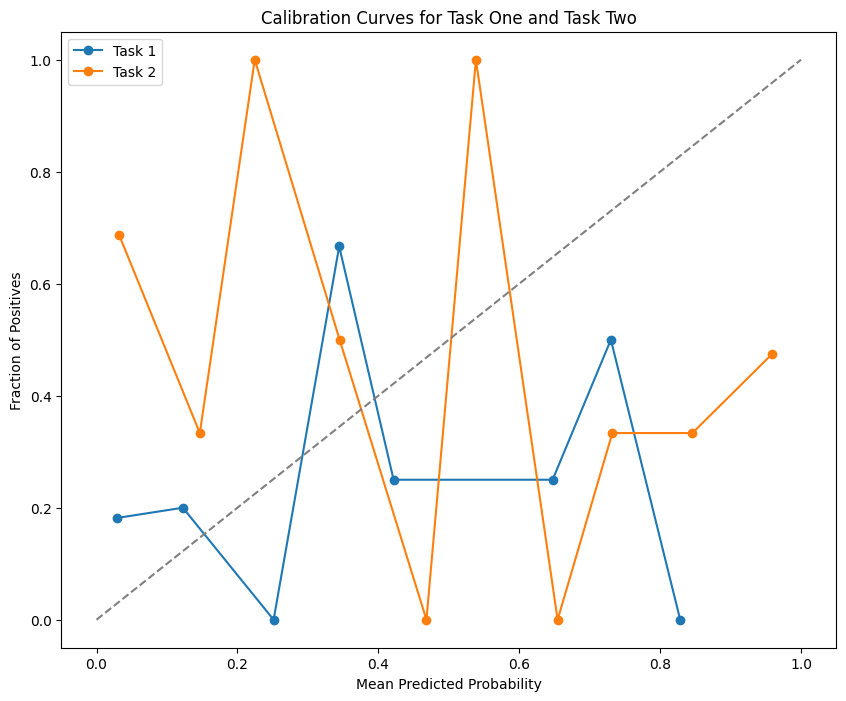

In [27]:
# Predictions and true labels
predictions = [pred.flatten() for pred in training_model.predict(preprocessed_val_ds)]

# Adjusted true labels extraction
true_labels = [
    np.concatenate(
        [labels[f"task_{suffix}"].numpy() for _, labels, _ in preprocessed_val_ds]
    )
    for suffix in ["one", "two"]
]

# Plotting calibration curves
plt.figure(figsize=(10, 8))
for i, (true, pred) in enumerate(zip(true_labels, predictions)):
    prob_true, prob_pred = calibration_curve(true, pred, n_bins=10)
    plt.plot(prob_pred, prob_true, marker="o", linestyle="-", label=f"Task {i+1}")

plt.plot([0, 1], [0, 1], linestyle="--", color="grey")  # Reference line
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curves for Task One and Task Two")
plt.legend()
plt.show()

In [28]:
pred = training_model.predict(preprocessed_val_ds)

# use zip to add scores for task one and task two into a df
df_preds_val = pd.DataFrame(
    zip(
        pred[0].flatten(),
        pred[1].flatten(),
    ),
    columns=["task_one_pred", "task_two_pred"],
)
pp.pprint(df_preds_val.head())

2/2 [==============================] - 1s 2ms/step
   task_one_pred  task_two_pred
0       0.019933       0.085958
1       0.002120       0.011221
2       0.423651       0.972596
3       0.449373       0.538516
4       0.828462       0.889940


# 7. Inference with the new E2E model


In [29]:
df_as_dict = {
    "age": [60, 60, 60, 60],
    "sex": [1, 1, 1, 1],
    "cp": [1, 1, 1, 1],
    "trestbps": [145, 145, 145, 145],
    "chol": [233, 233, 233, 233],
    "fbs": [1, 1, 1, 1],
    "restecg": [2, 2, 2, 2],
    "thalach": [150, 150, 150, 150],
    "exang": [0, 0, 0, 0],
    "oldpeak": [2.3, 2.3, 2.3, 2.3],
    "slope": [3, 3, 3, 3],
    "ca": [0, 0, 0, 0],
    "thal": ["fixed", "fixed", "fixed", "fixed"],
}

In [30]:
df = pd.DataFrame(df_as_dict)

ds = tf.data.Dataset.from_tensor_slices(dict(df))
ds = ds.batch(100)

In [31]:
predictions = inference_model.predict(ds)

1/1 [==============================] - 1s 1s/step


In [32]:
sample = {
    "age": 60,
    "sex": 1,
    "cp": 1,
    "trestbps": 145,
    "chol": 233,
    "fbs": 1,
    "restecg": 2,
    "thalach": 150,
    "exang": 0,
    "oldpeak": 2.3,
    "slope": 3,
    "ca": 0,
    "thal": "fixed",
}

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = inference_model.predict(input_dict)
pp.pprint(predictions)

print(
    f"This patient had a {100 * predictions[0][0][0]:.2f}% probability of heart disease "
    f"This patient had a {100 * predictions[1][0][0]:.2f}% probability of lung disease "
)

1/1 [==============================] - 1s 1s/step
[array([[0.3365623]], dtype=float32), array([[0.57184196]], dtype=float32)]
This patient had a 33.66% probability of heart disease This patient had a 57.18% probability of lung disease 


In [33]:
# Save the inference model to a file in the SavedModel format
inference_model_file_path = "inference_model/"
inference_model.save(inference_model_file_path, save_format="tf")

INFO:tensorflow:Assets written to: inference_model/assets


INFO:tensorflow:Assets written to: inference_model/assets


In [34]:
# Load the inference model from the file
loaded_inference_model = keras.models.load_model(inference_model_file_path)

In [35]:
predictions = loaded_inference_model.predict(input_dict)

print(
    f"This patient had a {100 * predictions[0][0][0]:.2f}% probability of heart disease "
    f"This patient had a {100 * predictions[1][0][0]:.2f}% probability of lung disease "
)

1/1 [==============================] - 1s 1s/step
This patient had a 33.66% probability of heart disease This patient had a 57.18% probability of lung disease 
